# Lab ML for Data Science: Part II
## Getting Insights into Quantum-Chemical Relations

### Joslin Maria Thomas, Manasi Madhav Acharya, Namrata De

In [1]:
import numpy as np
import scipy
import scipy.spatial.distance as distance
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import io
from collections import defaultdict
from scipy.spatial.distance import euclidean

from scipy.stats import norm
from scipy.optimize import  minimize
from scipy.spatial.distance import cdist

In [2]:
#Loading the dataset
qm7_data = scipy.io.loadmat('qm7.mat')

The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms. The 3d
coordinates of each atom in each molecule are available in the variable R. It is an array of size 7165×23×3
containing for each molecule and atom a triplet representing the 3d coordinates. The variable Z is an array
of size 7165×23 which gives for each molecule and atom of the molecule the corresponding atomic number.
An atomic number of 1 corresponds to a hydrogen atom (H), the number 6 corresponds to carbon (C), the
numbers 7 and 8 to nitrogen (N) and oxygen (O) respectively, and finally, the number 16 corresponds to
sulfur (S). If the number is zero, then it indicates that there is no atom at this index, and the corresponding
3d coordinate should therefore be ignored. This allows for representing in the same array molecules of
different sizes. In addition to these geometrical features of the molecule, the dataset also provides for
each molecule its atomization energy (computed via quantum-chemical simulation). These atomization
energy values are stored in the variable T, an array of size 7165.

QM7 DataSet
- Consists of 7165 molecules and its atomic structure, each molecule comprises 23 atoms
- Variable R: It has the 3D coordinates of each of the 23 atoms in a single molecule
- Variable Z: It has the atomic number of each atom in a molecule
- Variable T : It has the atomization energy


## Understanding the Dataset

In [3]:
qm7_data_coordinates = qm7_data['R']
print("Every molecule has n atoms(n<=23) and each atom has 3 coordinates, therefore the shape of array is :",qm7_data_coordinates.shape)
print("3D coordinates of atoms of first molecule:")
qm7_data_coordinates[0][:5]

Every molecule has n atoms(n<=23) and each atom has 3 coordinates, therefore the shape of array is : (7165, 23, 3)
3D coordinates of atoms of first molecule:


array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ]], dtype=float32)

As  expected R has shape 7165 x 23 x 3 i.e. (number of molecules) x (number of atoms) x(3D coordinates)

In [4]:
qm7_data_atomic_number = qm7_data['Z']
print("Every molecule has n atoms(n<=23) and hence shape of the array is ", qm7_data_atomic_number.shape)
qm7_data_atomic_number

Every molecule has n atoms(n<=23) and hence shape of the array is  (7165, 23)


array([[6., 1., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       [6., 6., 1., ..., 0., 0., 0.],
       ...,
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.],
       [6., 6., 6., ..., 0., 0., 0.]], dtype=float32)

atomic number 0 signifies no atom

The atomization energy of a molecule is the energy generated by dissociating all atoms from the
molecule, i.e. moving atoms far apart so that the bonds between atoms are broken. Because it consumes
energy to break these bonds, the atomization energy is typically a negative quantity.

In [5]:
qm7_data_atomization_energy = qm7_data['T']
print("Shape: ", qm7_data_atomization_energy.shape)
print("Atomization Energy: ",qm7_data_atomization_energy)

Shape:  (1, 7165)
Atomization Energy:  [[ -417.96  -712.42  -564.21 ... -1662.1  -1782.01 -1919.  ]]


## 1.1 Visualizing The Molecule

#### Plotting of the first 6 molecules

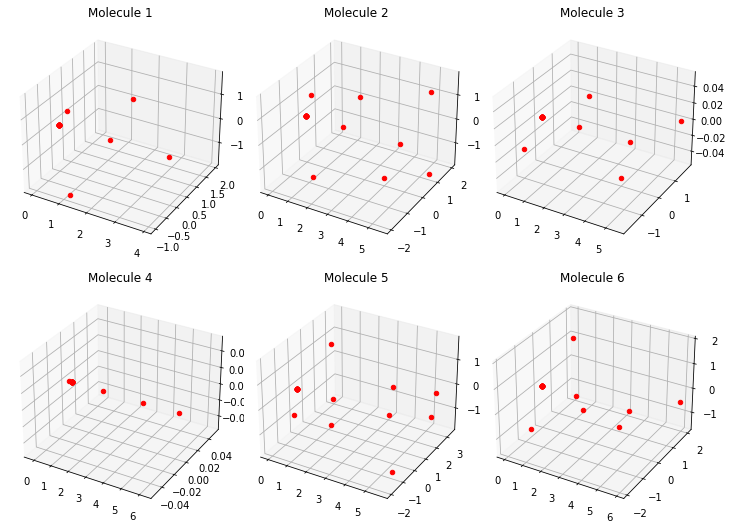

In [6]:
import matplotlib.pyplot as plt

molecules = qm7_data_coordinates[0:6]
color = 'red'  # Specify the desired color for all molecules

fig, axs = plt.subplots(2, 3, subplot_kw={'projection': '3d'},figsize=(10, 8))
fig.subplots_adjust(hspace=1, wspace=1.5)  # Adjust the spacing between subplots

counter = 0
for molecule, ax in zip(molecules, axs.flat):
    counter += 1
    for atom in molecule:
        x, y, z = atom
        ax.scatter(x, y, z, c=color, marker='o')
    ax.set_title(f"Molecule {counter}")

plt.tight_layout()
plt.show()


Out of the 23 atom coordinates given, first molecule has 5 valid atoms, since the rest of the atomic numbers are 0. To find out the closest bond, based on a distance threshold, we need to consider only the valid atoms

In [7]:
non_zero_index = []
for atomic_number in qm7_data_atomic_number:
    non_zero_index.append(sum(1 for element in atomic_number if element != 0))
# len(non_zero_index) = 7165

In [8]:
non_zero_coordinates =[]
for i,molecule in enumerate(qm7_data_coordinates):
    non_zero_coordinates_molecule = molecule[:non_zero_index[i]]
    non_zero_coordinates.append(non_zero_coordinates_molecule)
print("As described above, first molecule has only 5 valid atoms, and the coordinates are given by :")
non_zero_coordinates[0]

As described above, first molecule has only 5 valid atoms, and the coordinates are given by :


array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ]], dtype=float32)

Let's look at this graphically, and for distance threshold of 2.5, let's create bonds between each atom in the first molecule

In [9]:

def plot_scatter_with_labels(coordinates, threshold):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract x, y, z coordinates separately
    x_coords, y_coords, z_coords = zip(*coordinates)

    # Plot scatterplot
    ax.scatter(x_coords, y_coords, z_coords)

    # Check distance between each pair of points
    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            # Calculate Euclidean distance
            dist = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))

            # Draw line if distance is below the threshold
            if dist < threshold:
                ax.plot([x_coords[i], x_coords[j]], [y_coords[i], y_coords[j]], [z_coords[i], z_coords[j]], color='red')

    # Add labels for each point
    for i, (x, y, z) in enumerate(coordinates):
        ax.text(x, y, z, f'Atom {i}', color='black',fontsize = 8)

    # Set labels and display the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()




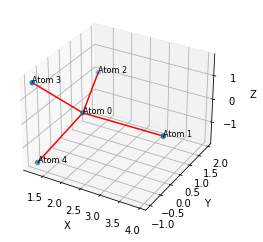

In [10]:
#plotting first molecule CH4
plot_scatter_with_labels(non_zero_coordinates[0],threshold = 2.5)



Given that this molecule has one Carbon atom and 4 Hydrogen atoms, it is CH4 which we know that has the same structure, where central atom C is linked to 4 Hydrogens

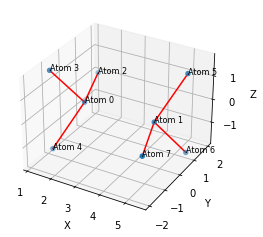

In [11]:
#plotting second molecule C2H6

plot_scatter_with_labels(non_zero_coordinates[1],threshold = 2.5)


However, we know that in C2H6, there is a bond between the two Carbon atoms. So we decided to move the distance threshold to 3 for a more accurate representation (based on the first two molecules at least).

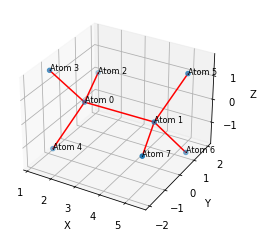

In [12]:
plot_scatter_with_labels(non_zero_coordinates[1],threshold = 3)


## 2.1 Data Representation

- Making a standardised list of all possible atom types
    -The idea is to create onehot encoding for all valid atoms in a molecule.

In [13]:
unique_atoms = np.unique(qm7_data_atomic_number, axis=None)
unique_atoms

array([ 0.,  1.,  6.,  7.,  8., 16.], dtype=float32)

We can see that the atomic number array has 6 unique numbers out of which 0 is invalid representing no atom.
To do regression on the atoms, as a function of each unique atom in a molecule, we need to have uniform representation of each molecule.
To achieve that and to help in further explanation, we onehot encode each atom and then sum it over unique atoms.

In [14]:
'''
In this step we have one-hot encoded each atom
Example: In first molecule we have one C and 4 H and rest are invalid atoms
Since 0 is the first element in the unique atom list, the first position of the encoder is for 0 and second for atomic number 1 (H) and so on
Therefore in this representation we have one C - represented as (0,0,1,0,0,0) and H as (0,1,0,0,0,0):

'''


unique_atoms_list = unique_atoms.tolist()
unique_atoms_list.remove(0)
print("unique_atoms_list", unique_atoms_list)
onehot_encoding = [
    [[1 if atom == unique_atom else 0 for unique_atom in unique_atoms_list] for atom in molecule]
    for molecule in qm7_data_atomic_number
]

onehot_encoding[0]

unique_atoms_list [1.0, 6.0, 7.0, 8.0, 16.0]


[[0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]

In [15]:
'''
As explained above, for each molecule, now we sum over one hot encoding of each atom to get uniform representation by each unique atom
'''
one_hot_encoded_array = np.array(onehot_encoding)
one_hot_df = pd.DataFrame(np.sum(one_hot_encoded_array, axis=1), columns=unique_atoms_list)
one_hot_df_array = one_hot_df.to_numpy()
one_hot_df_array.shape
one_hot_df_array[:5]

array([[4, 1, 0, 0, 0],
       [6, 2, 0, 0, 0],
       [4, 2, 0, 0, 0],
       [2, 2, 0, 0, 0],
       [6, 2, 0, 1, 0]])

## 2.2 Ridge Regression Model

Our aim is to run a Ridge Regression Model where our features are the molecular structure we see above and our target is to predict the atomization energy.

In [16]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

Preparing the data to fit into RidgeRegression Model

In [17]:
X=one_hot_df_array
Y=qm7_data_atomization_energy.reshape(-1, 1)
#Splitting the data in train and test and validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# Scaling after splitting
X_train_scaled= scaler_X.fit_transform(X_train)
X_test_scaled= scaler_X.transform(X_test)
X_val_scaled = scaler_X.transform(X_val)

y_train_scaled=scaler_Y.fit_transform(y_train)
y_test_scaled=scaler_Y.transform(y_test)
y_val_scaled = scaler_Y.transform(y_val)

On scaled data we run the ridge regressor, which needs the regularization parameter as well.
The regularization parameter needs to be optimised based on the improvement in mean squared error.


In [18]:
best_lambda = None
best_mse = np.inf
lambda_values = [0.01*i for i in range(1,10)]
for lambda_val in lambda_values:
    # Step 3: Create and train the Ridge regression model
    ridge = Ridge(alpha=lambda_val,fit_intercept=False)
    ridge.fit(X_train_scaled, y_train_scaled)

    # Step 4: Make predictions and evaluate the model
#     y_pred = ridge.predict(X_test_scaled)
    y_val_pred = ridge.predict(X_val_scaled)

    mse = mean_squared_error(y_val_scaled, y_val_pred)

    # Check if this lambda value gives the best MSE so far
    if mse < best_mse:
        best_mse = mse
        best_lambda = lambda_val
print(best_lambda)

0.09


In [19]:
ridge = Ridge(alpha=best_lambda, fit_intercept=False)
# ridge.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train_scaled)

#w vector
ridge_weights=ridge.coef_
ridge_weights

array([[-0.78542092, -0.63865221, -0.36023638, -0.33025999, -0.07239034]])

In [20]:
ridge_result_on_y_test_scaled = ridge.predict(X_test_scaled)
ridge_result_on_y_test_scaled

array([[-1.69716115],
       [ 0.18171652],
       [ 1.11442583],
       ...,
       [-0.37412255],
       [-0.76810779],
       [-1.63666172]])

In [21]:
y_test_scaled  #original y valuues (scaled)

array([[-1.6660537 ],
       [ 0.24540643],
       [ 1.0429877 ],
       ...,
       [-0.37257874],
       [-0.8183185 ],
       [-1.695187  ]], dtype=float32)

Predictions from ridge in the cell above seems to match actual values (both scaled)


In [22]:
print(f"Maximum error is between predicted and actual atomization energy: {round((ridge_result_on_y_test_scaled - y_test_scaled).max(),4)}")  #max diff between predicted and actual y
print(f"Average error in predicted and actual atomization energy: {round((ridge_result_on_y_test_scaled - y_test_scaled).mean(),4)}")

Maximum error is between predicted and actual atomization energy: 0.2697
Average error in predicted and actual atomization energy: -0.0049


We can show that weights we receive from Ridge Regression matches the weights we get from the closed form solution

In [23]:
def closed_form_solution(X, y, lambda_val):

    # Compute auto- and cross-covariance matrices
    Sigma_xx = (X.T @ X)
    Sigma_xt = (X.T @ y)

    # Add regularization term to auto-covariance matrix
    reg_term = lambda_val * np.eye(X.shape[1])
    Sigma_xx_reg = Sigma_xx + reg_term

    # Compute the parameter vector w
    w = np.dot(np.linalg.inv(Sigma_xx_reg), Sigma_xt)

    return w

In [24]:
weight_closed_form =closed_form_solution(X_train_scaled,y_train_scaled,lambda_val=best_lambda)
weight_closed_form

array([[-0.78542092],
       [-0.63865221],
       [-0.36023638],
       [-0.33025999],
       [-0.07239034]])

## 2.3 Deeper Insights with Explanations

\begin{align*}
f(x) &= w^T \cdot (X scaled) \\
&= w^T \cdot (X - X_{\text{mean}}) \\
&= (w^T \cdot X) - (w^T \cdot X_{\text{mean}}) \\
&= (w^T \cdot X) - Average Atomization Energy \\
Also, \\
f(x)&= w^T \cdot \left(\sum \text{(one hot encodings)} - X_{\text{mean}}\right) \\
&= w^T \cdot \sum \text{(one hot encodings)} - w^T \cdot X_{\text{mean}} \\
&= \sum \left(w^T \cdot \text{(one hot encodings)}\right) - w^T \cdot X_{\text{mean}}\\
&= \sum \left(w^T \cdot \text{(one hot encodings)}\right) - Average Atomization Energy
\end{align*}

For each molecule, we see how much the atomization energy varies as compared to the average atomization energy

In [25]:
ridge_weights

array([[-0.78542092, -0.63865221, -0.36023638, -0.33025999, -0.07239034]])

In [26]:
# We pick a random molecule from our dataset
molecule_index = 5732
oh= onehot_encoding[molecule_index]

In [27]:
one_hot_df.iloc[molecule_index]

1.0     5
6.0     4
7.0     1
8.0     2
16.0    0
Name: 5732, dtype: int64

This molecule has 5 H, 4C, 1N and 2 O, i.e. a total of 12 atoms

In [28]:
molecule_relevance_by_atom = ridge_weights @ np.array(oh).T
#Relevance of each atom in predicting y (target feature) = w.T . onehotencoding
molecule_relevance_by_atom

array([[-0.36023638, -0.63865221, -0.63865221, -0.63865221, -0.63865221,
        -0.33025999, -0.33025999, -0.78542092, -0.78542092, -0.78542092,
        -0.78542092, -0.78542092,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

The first atom in this molecule is N which contributes -0.360236 to the total atomization energy of -7.5, Similar analysis can be done for other molecules to determine the individual atom contribution.

\begin{align*}
\text {We can show that } w^T \cdot X = \sum \left(w^T \cdot \text{one hot encodings}\right).
\end{align*}

In [29]:
ridge_weights @ X[5732]  # y for 5732nd molecule = w.T . X

array([-7.50246979])

In [30]:
(ridge_weights @ np.array(oh).T).sum() #Sum of each individual atom's contribution = Sum(w.T . onehotencoding)
# which is same as w.T . X which we see in the cell above

-7.502469785542177

### 3.1 Simple atom-based Representation

We have modelled the atomization energy as a function of 5 features which are the atom types available : H,C,S,O,N.  The purpose now is to explain the contribution of each feature to atomizatiion energy. As we can see above, the driver of atomization energy is the product of ridge weights and the feature, which can also be expressed as the summation of the product of ridge weights and the individual one hot encodings.

In [31]:
def oh_relevance_all(oh):
    oh_df = pd.DataFrame(oh,columns = one_hot_df.columns)
    molecule_relevance_by_atom = ridge_weights @ np.array(oh).T
    oh_df["relevance"] = molecule_relevance_by_atom.reshape(-1,1)
    return oh_df 

# one hot encoding and the relevance per atom for each molecule
oh_relevance_all_list=[]
for oh in onehot_encoding:
    oh_relevance_all_list.append(oh_relevance_all(oh))
# len(oh_relevance_all_list)


# one hot encoding and relevance per atom for a random molecule from our dataset
random_molecule_index = random.randint(0, len(oh_relevance_all_list))
oh_relevance_all_list[random_molecule_index]

,1.0,6.0,7.0,8.0,16.0,relevance
0,0,1,0,0,0,-0.638652
1,0,1,0,0,0,-0.638652
2,0,0,0,1,0,-0.330260
3,0,1,0,0,0,-0.638652
4,0,1,0,0,0,-0.638652
5,0,1,0,0,0,-0.638652
6,0,0,0,1,0,-0.330260
7,1,0,0,0,0,-0.785421
8,1,0,0,0,0,-0.785421
9,1,0,0,0,0,-0.785421


### 3.2 Models with Pairs of Atoms
So far we  have looked at unique atom types and their influence on the atomization energy.
This section focuses on improving the model by considering the distances between pair of atoms, as same set of atoms could have different bond length/strength.

Total number of pairwise distances: 824783


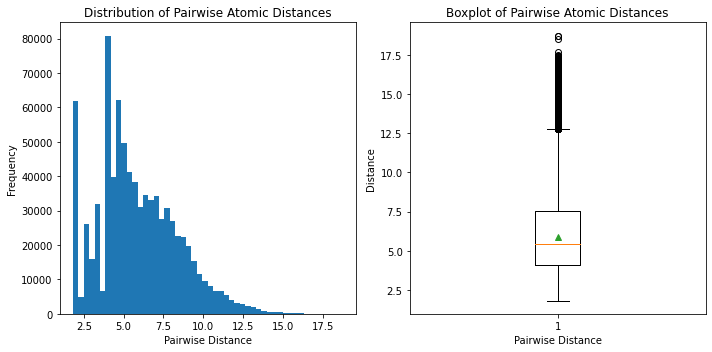

In [32]:
# Calculate pairwise distances for each molecule
pairwise_distances = []
total_distance_count = 0  # Initialize distance count
distance_count_list = []

for molecule in non_zero_coordinates:
    distances = []
    num_atoms = len(molecule)
    atom_coordinates = np.array(molecule)  # Convert the list of coordinates to a numpy array
    distance_count = 0
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            distance = np.linalg.norm(atom_coordinates[i] - atom_coordinates[j])
            distances.append(distance)
            distance_count += 1  # Increment distance count
    pairwise_distances.extend(distances)
    total_distance_count += distance_count  # Add distance count for current molecule to total count
    distance_count_list.append(distance_count)

print("Total number of pairwise distances:", total_distance_count)

# Plot the distribution of pairwise distances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# Histogram
ax1.hist(pairwise_distances, bins=50)
ax1.set_xlabel('Pairwise Distance')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Pairwise Atomic Distances')
# Boxplot
# Create the boxplot
boxplot = ax2.boxplot(pairwise_distances, showmeans=True, showfliers=True)

# Add labels and title
ax2.set_xlabel('Pairwise Distance')
ax2.set_ylabel('Distance')
ax2.set_title('Boxplot of Pairwise Atomic Distances')


plt.tight_layout()
plt.show()



In [33]:
mean_distance = np.mean(pairwise_distances)
std_distance = np.std(pairwise_distances)
var_distance = np.var(pairwise_distances)

print("Overall minimum distance:", min(pairwise_distances))
print("Overall maximum distance:", max(pairwise_distances))
print("Mean distance:", mean_distance)
print("Standard deviation:", std_distance)
print("Variance:", var_distance)

Overall minimum distance: 1.826536
Overall maximum distance: 18.717451
Mean distance: 5.89301
Standard deviation: 2.5131466
Variance: 6.3159056


In the updated function (create_soft_encoding), a soft indicator function based on a Gaussian distribution is used. Instead of assigning a binary value of 1 or 0, the soft encoding assigns a real-valued weight to each interval based on the Gaussian distribution centered at the midpoint of the interval. The weight decreases as the distance moves away from the center of the interval, following the Gaussian curve. This soft encoding allows for a smoother representation of the distances, capturing the gradual transition between intervals and avoiding abrupt discontinuities.

The use of a soft encoding with a Gaussian distribution provides a continuous representation of the distances

In [34]:
# Intial Guesses of parameters for building

# phi_A
end_of_interval = 6
number_of_intervals = 100
variance = 0.01


\begin{align*}
\text{building } \phi_A
\end{align*}


In [35]:
"""
    Creates intervals of equal length from 0 to the given end value.

    Args:
        end (float): The end value of the intervals.
        interval_count (int): The number of intervals to create.

    Returns:
        np.ndarray: An array containing the intervals with their start, end, and average values.
"""

def create_intervals(end:float,interval_count:int,):
    start = 0
    interval_length = (end - start) / interval_count

    intervals = []
    for i in range(interval_count):
        interval_start = start + i * interval_length
        interval_end = start + (i + 1) * interval_length
        intervals.append((interval_start, interval_end))

    intervals = np.array(intervals).reshape(-1, 2)  # Convert intervals to a NumPy array with shape (num_intervals, 2)
    average = np.expand_dims(np.mean(intervals, axis=1), axis=1)
    intervals = np.concatenate((intervals, average), axis=1)
    return intervals

In [36]:
'''
The create_soft_encoding function takes a dataset, intervals of distances, and a variance of Gaussian Distribution
as input, where the mean of the Gaussian Distribution is the Center point of each interval. 

The soft encodings provide a representation of the atom distances in a more continuous and flexible manner.
'''

def create_soft_encoding(dataset, intervals, variance):
    soft_encodings = []

    for molecule in dataset:
        molecule = np.array(molecule)
        num_atoms = len(molecule)
        num_pairs = num_atoms * (num_atoms - 1) // 2

        #distances = np.linalg.norm(molecule[:, np.newaxis, :] - molecule[np.newaxis, :, :], axis=2)
        distances = cdist(molecule, molecule)
        encodings = np.zeros((num_pairs, len(intervals)))

        pair_idx = 0
        for i in range(num_atoms):
            for j in range(i + 1, num_atoms):
                distance = distances[i, j]
                value=norm.pdf(distance, loc=intervals[:, 2], scale=variance**0.5)
                encodings[pair_idx, :] = np.round(value,5)
                pair_idx += 1

        soft_encodings.append(encodings)

    return soft_encodings

In [37]:
intervals = create_intervals(end =end_of_interval,interval_count=number_of_intervals)
phiA = create_soft_encoding(non_zero_coordinates, intervals, variance)

\begin{align*}
\text{building } \phi_B
\end{align*}


In [38]:
'''
The function map_atoms takes an atom array as input and maps the atom numbers to their 
corresponding atom names using a predefined mapping dictionary. 
'''

def map_atoms(atom_array):
    atom_mapping = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 16: 'S'}

    # Remove zeroes from the array
    non_zero_indices = np.nonzero(atom_array)[0]
    non_zero_atoms = atom_array[non_zero_indices]

    # Map each number to its relevant atom name
    atom_names = [atom_mapping[atom] for atom in non_zero_atoms]

    return atom_names


# Apply the mapping to all molecules
mapped_molecules = [map_atoms(molecule) for molecule in qm7_data_atomic_number]

print("Mapped First Molecule:", mapped_molecules[0])

Mapped First Molecule: ['C', 'H', 'H', 'H', 'H']


In [39]:
'''
The generate_bond_encoding function takes a list of mapped molecules, a list of unique atoms present in dataset, 
atom coordinates, and a threshold. It computes bond encodings for each molecule based on pairwise distances 
between atoms, where a bond is formed if the distance is below the threshold. 
The bond encodings are stored in a list, and distance information is also collected in a list of dictionaries.
'''


# List of dicts to store distance information
distance_info = []
unique_atoms_names=['H', 'C', 'N', 'O', 'S']
def generate_bond_encoding(mapped_molecules, unique_atoms_list, atom_coordinates, threshold):
    unique_bonds_list = [atom1 + atom2 for atom1 in unique_atoms_list for atom2 in unique_atoms_list if atom1 <= atom2]
    # print("unique bonds: ", unique_bonds_list)
    # Convert atom_coordinates to numpy array
    atom_coordinates = np.array(atom_coordinates, dtype=object)

    # Create an empty bond encoding list
    bond_encoding = []

    # Iterate over the molecules
    for i, molecule in enumerate(mapped_molecules):

        distance_list = []
        bond_rows = []  # List to store bond rows for the current molecule

        # Iterate over the atoms in the molecule
        for j in range(len(molecule)):
            # Iterate over the atoms after the current atom to find bonds
            for k in range(j + 1, len(molecule)):
                # Calculate the pairwise distance between the atoms
                distance = euclidean(atom_coordinates[i][j], atom_coordinates[i][k])
                atom_pair = molecule[j] + "-" + molecule[k]
#                 print("Distance between", atom_pair, ":", distance)

                distance_list.append({"Molecule": i, "Atom Pair": atom_pair, "Distance": distance})

                # Check if the distance is above the threshold for bond formation
                if distance < threshold and distance != 0:
                    # Create the bond by concatenating the atom names
                    bond = molecule[j] + molecule[k]
                    bond_row = [1 if b == bond else 0 for b in unique_bonds_list]
                    bond_rows.append(bond_row)
                else:
                    bond_row = [0] * len(unique_bonds_list)
                    bond_rows.append(bond_row)

        bond_encoding.append(bond_rows)
        distance_info.append(distance_list)

    return bond_encoding



In [40]:
# Intial Guesses of parameters for building

# phi_B
bond_threshold = 2.5


In [41]:
phiB = generate_bond_encoding(mapped_molecules=mapped_molecules,
                              unique_atoms_list=unique_atoms_names,atom_coordinates=non_zero_coordinates,threshold = bond_threshold)


### Visualization of Soft Encoding (for the 1st molecule):

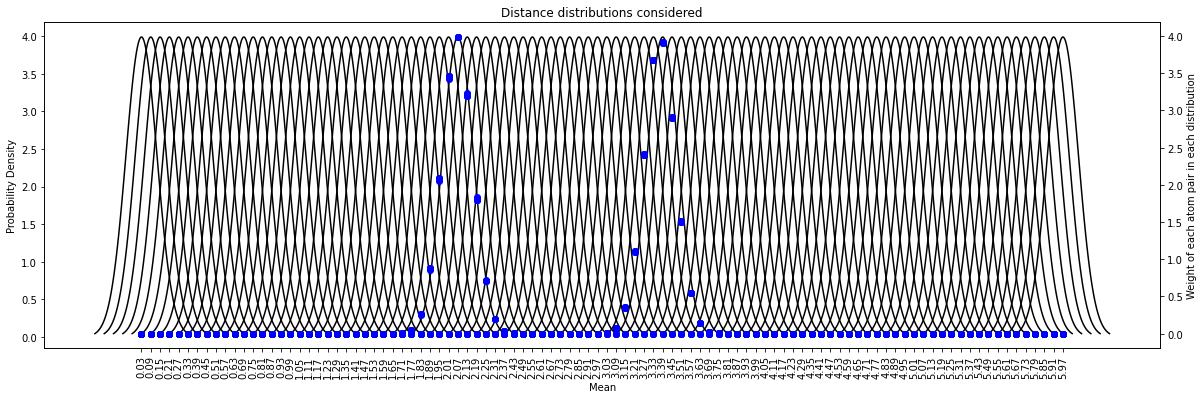

In [42]:
mean_values = intervals[:,2]
data = phiA[0]
# Create a figure and axis for the plot
fixed_variance = variance


# Create a figure and axis for the plot
fig = plt.figure(figsize=(20, 6))  # Set the width and height of the figure

# Create a subplot
ax1 = fig.add_subplot()
ax2 = ax1.twinx()

# Generate a color for the scatter points
color = 'blue'

# Iterate over each column of the data array and the mean values
for i in range(data.shape[1]):
    # Plot the scatter points for the current dimension with the same color
    ax2.scatter(np.full(10, mean_values[i]), data[:, i], color=color)

    # Generate x-values for the PDF
    x = np.linspace(mean_values[i] - 3 * np.sqrt(fixed_variance), mean_values[i] + 3 * np.sqrt(fixed_variance), 100)

    # Calculate the PDF using the mean and fixed variance
    pdf = norm.pdf(x, loc=mean_values[i], scale=np.sqrt(fixed_variance))

    # Plot the PDF with no label
    ax1.plot(x, pdf, label=f"Dimension {i + 1}",color = "black",)

# Set labels and title
ax1.set_xticks(np.round(intervals[:,2], decimals=2))
ax1.set_xlabel('Mean')
ax1.set_ylabel('Probability Density')
ax2.set_ylabel('Weight of each atom pair in each distribution')
ax1.set_title('Distance distributions considered')

ax1.set_xticklabels(ax1.get_xticks(), rotation=90)
plt.show()

In [43]:
distance_info[0]

[{'Molecule': 0, 'Atom Pair': 'C-H', 'Distance': 2.063549041748047},
 {'Molecule': 0, 'Atom Pair': 'C-H', 'Distance': 2.0635344982147217},
 {'Molecule': 0, 'Atom Pair': 'C-H', 'Distance': 2.0635828971862793},
 {'Molecule': 0, 'Atom Pair': 'C-H', 'Distance': 2.0651566982269287},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.37018084526062},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.3701982498168945},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.3706564903259277},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.370192527770996},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.3706531524658203},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.3706717491149902}]

We have 10 pairwise distances between the atoms, where distance between C and H are 2.06 and 3.07 between H and H.

With our soft encoding we have a peak on the distributions with mean 2.07 and 3.39, which seems to match the empirical data.

Creating ϕA * ϕB

In [44]:
"""
ϕA : Soft Encoding
ϕB : Bond Encoding

The feature maps ϕA and ϕB can be combined into one ‘big’ feature map consisting e.g. of all
products between elements of the two feature maps.

"""

def phi_Axphi_B(result,bond_encoding):
    mul_result=result.T @ bond_encoding
    result_flat=mul_result.flatten()
    return result_flat

### Ridge Regression on the updated molecule representation

In [45]:
# Intial Guesses of parameters for building

# Ridge Regression
lambda_val = 0.01

In [46]:
"""
    Runs ridge regression on the given data using specified parameters and returns the mean squared error (MSE)
    of the validation set.

    Args:
        end_of_interval (float): The end value of the interval for creating intervals.
        number_of_intervals (int): The number of intervals to create.
        variance: The variance parameter used in creating soft encodings.
        bond_threshold: The threshold for bond formation in generating bond encodings.
        lambda_val (float): The regularization parameter for ridge regression.

    Returns:
        float: The mean squared error (MSE) of the validation set.
    """


def run_ridge_regression(end_of_interval:float,number_of_intervals:int,variance,bond_threshold,lambda_val):

    intervals = create_intervals(end =end_of_interval,interval_count=number_of_intervals)
    phiA = create_soft_encoding(non_zero_coordinates, intervals, variance)
    phiB = generate_bond_encoding(mapped_molecules=mapped_molecules,
                                  unique_atoms_list=unique_atoms_names,atom_coordinates=non_zero_coordinates,threshold = bond_threshold)
    phi_A_phi_B_all=[]
    for i in range(len(phiA)):
        phi_A_phi_B_all.append(phi_Axphi_B(phiA[i],phiB[i]))
    flattened_X = np.array(phi_A_phi_B_all)
    X_scaler = StandardScaler()
    Y_scaler = StandardScaler()
    Y=qm7_data_atomization_energy.reshape(-1, 1)
    #Splitting the data in train and test and validation
    X_train, X_test, y_train, y_test = train_test_split(flattened_X, Y, test_size=0.2, random_state=42,)
    X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

    # Scaling after splitting
    X_train_scaled= X_scaler.fit_transform(X_train)
    #X_test_scaled= X_scaler.transform(X_test)
    X_val_scaled = X_scaler.transform(X_val)

    y_train_scaled=Y_scaler.fit_transform(y_train)
    #y_test_scaled=Y_scaler.transform(y_test)
    y_val_scaled = Y_scaler.transform(y_val)



    ridge = Ridge(alpha=lambda_val,fit_intercept=False)
    ridge.fit(X_train_scaled, y_train_scaled)

    y_val_pred = ridge.predict(X_val_scaled)

    mse = mean_squared_error(y_val_scaled, y_val_pred)
    print(mse)
    return mse


In [47]:
#We can also implement this section to optimize the parameters



# """
#     Optimizes the parameters ϕA and ϕB such as interval range, number of intervals, variance, 
#     threshold distance for bond, ridge parameter lambda.
    
#     Args:
#         params (List[Any]): List of initial parameter values 
#         [end_of_interval, number_of_intervals, variance, bond_threshold, lambda_val].

#     Returns:
#         float: The mean squared error (MSE) of the ridge regression model with the optimized parameters.
#     """


# def optimize_parameters(params):
#     end_of_interval, number_of_intervals, variance, bond_threshold, lambda_val = params

#     # Call the run_ridge_regression() function with the given parameters
#     mse = run_ridge_regression(end_of_interval, int(number_of_intervals), variance, bond_threshold, lambda_val)

#     return mse

# # Example initial parameter values
# initial_params = [6, int(100), 0.01, 2.5, 0.01]
# # options = {'maxiter': 5}
# # Perform optimization
# # result = minimize(optimize_parameters, initial_params,options=options)
# result = minimize(optimize_parameters, initial_params)


# # Get the optimized parameters
# optimized_params = result.x

# # Print the optimized parameters
# print("Optimized Parameters:", optimized_params)

In [48]:
#Now we have our optimized parameters

end_of_interval = 6
number_of_intervals = 100
variance = 0.01
bond_threshold = 2.5
lambda_val = 0.01

Building Optimized Phi_A and Phi_B

In [49]:
intervals = create_intervals(end =end_of_interval,interval_count=number_of_intervals)
phiA = create_soft_encoding(non_zero_coordinates, intervals, variance)

phiB = generate_bond_encoding(mapped_molecules=mapped_molecules,
                              unique_atoms_list=unique_atoms_names,atom_coordinates=non_zero_coordinates,threshold = bond_threshold)



\begin{align*}
\text{Seeing the result of  } \phi_A * \phi_B \text{  for the first molecule}
\end{align*}


The first molecule has 1 C and 4 H, therefore, number of atoms (n) = 5 and number of pairwise distances is = n * (n-1)/2 = 10

In [87]:
# phiA[0]  #phi_A
# shape (10, optimized interval range=)

In [51]:
phiB[0]  #phi_B
# shape (10, 15)

[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [52]:
phi_A_phi_B = phiA[0].T @ phiB[0] #phi_A * phi_B for first molecule
phi_A_phi_B

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
phi_A_phi_B.shape

(100, 15)

In [54]:
phi_A_phi_B_all=[]
for i in range(len(phiA)):
    phi_A_phi_B_all.append(phi_Axphi_B(phiA[i],phiB[i]))

In [55]:
(np.array(phi_A_phi_B_all)).shape

(7165, 1500)

In [56]:
phi_A_phi_B_all[0].shape

(1500,)

### Ridge Regression on the updated molecule representation with optimized parameters

In [57]:
flattened_X = np.array(phi_A_phi_B_all)

X_scaler = StandardScaler()
Y_scaler = StandardScaler()
Y=qm7_data_atomization_energy.reshape(-1, 1)
#Splitting the data in train and test and validation
X_train, X_test, y_train, y_test = train_test_split(flattened_X, Y, test_size=0.2, random_state=42,)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# Scaling after splitting
X_train_scaled= X_scaler.fit_transform(X_train)
X_test_scaled= X_scaler.transform(X_test)
X_val_scaled = X_scaler.transform(X_val)

y_train_scaled=Y_scaler.fit_transform(y_train)
y_test_scaled=Y_scaler.transform(y_test)
y_val_scaled = Y_scaler.transform(y_val)


In [58]:
ridge_pair = Ridge(alpha=lambda_val,fit_intercept=False)
ridge_pair.fit(X_train_scaled, y_train_scaled)

Ridge(alpha=0.01, fit_intercept=False)

In [59]:
ridge_pair_weights=ridge_pair.coef_  #shape 1*1500
ridge_result_on_y_test_scaled = ridge_pair.predict(X_test_scaled)
ridge_result_on_y_test_scaled

array([[-1.45960588],
       [-0.16347894],
       [ 0.89601986],
       ...,
       [-0.4992985 ],
       [-0.68172753],
       [-1.52054651]])

In [60]:
y_test_scaled

array([[-1.6660537 ],
       [ 0.24540643],
       [ 1.0429877 ],
       ...,
       [-0.37257874],
       [-0.8183185 ],
       [-1.695187  ]], dtype=float32)

In [61]:
print(f"Maximum error is between predicted and actual atomization energy: {round((ridge_result_on_y_test_scaled - y_test_scaled).max(),4)}")  #max diff between predicted and actual y
print(f"Average error in predicted and actual atomization energy: {round((ridge_result_on_y_test_scaled - y_test_scaled).mean(),4)}")

Maximum error is between predicted and actual atomization energy: 22.7402
Average error in predicted and actual atomization energy: 0.0165


#### Calculating Pairwise Potential for the first molecule:

In [82]:
X_one_molecule = flattened_X[0]
molecule_relevance_by_each_feature = ridge_pair_weights * np.array(X_one_molecule) #=𝑤⋅𝑝ℎ𝑖𝐴∗𝑝ℎ𝑖𝐵
molecule_relevance_by_each_feature = molecule_relevance_by_each_feature.reshape(phi_A_phi_B.shape)
molecule_relevance_by_each_feature.shape

(100, 15)

In [83]:
unique_bonds_list = [atom1 + atom2 for atom1 in unique_atoms_names for atom2 in unique_atoms_names if atom1 <= atom2]

In [84]:
intervals_mean = np.round(intervals[:,2], decimals=2)

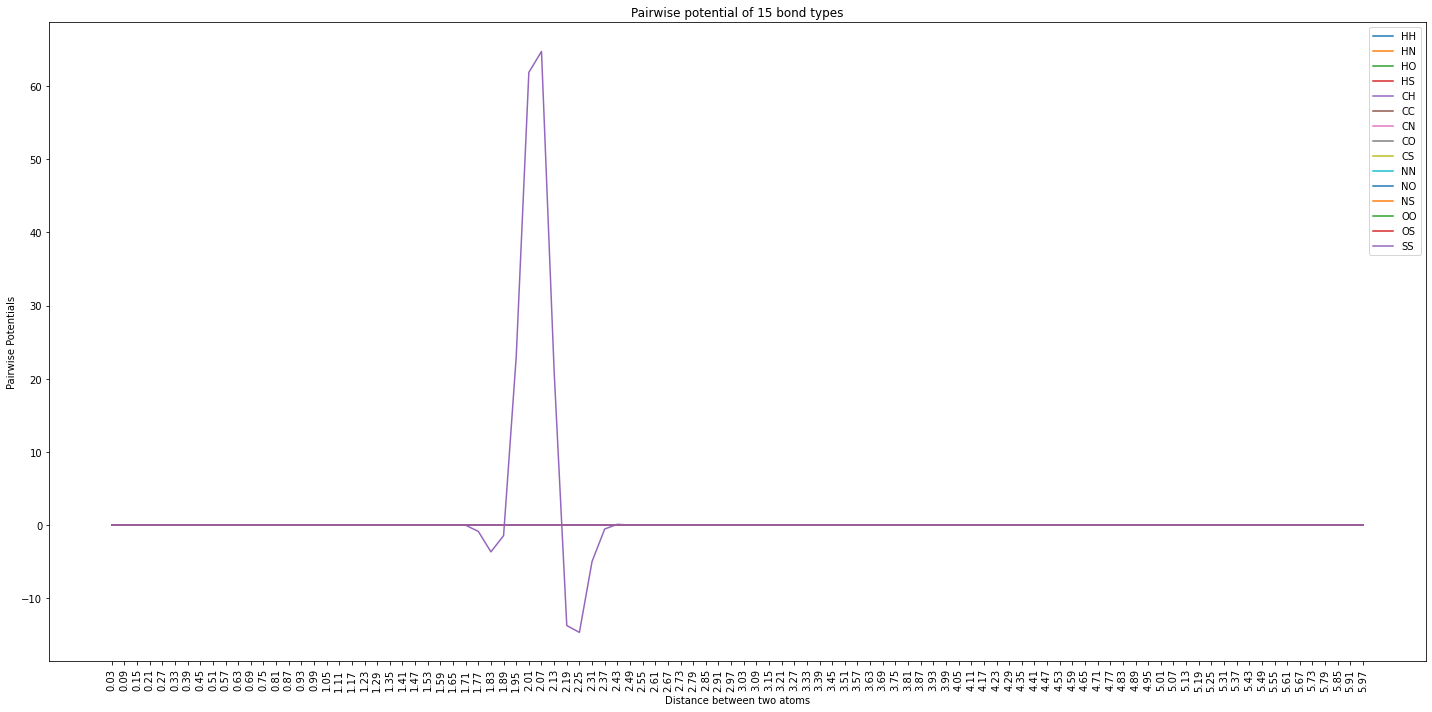

In [85]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 10))

# Plot a line for each column
for column in range(molecule_relevance_by_each_feature.shape[1]):
    ax.plot(molecule_relevance_by_each_feature[:, column])


# Show the plot
x=intervals_mean
num_ticks = 100
# Adjust the number of ticks as needed
tick_positions = np.linspace(0, len(x) - 1, num_ticks, dtype=int)
tick_labels = ['{:.2f}'.format(val) for val in x[tick_positions]]
plt.xticks(tick_positions, tick_labels,rotation=90)
plt.xlabel("Distance between two atoms")
plt.ylabel("Pairwise Potentials")
plt.title("Pairwise potential of 15 bond types")
plt.legend(unique_bonds_list)
plt.tight_layout()
plt.show()

In [86]:
distance_info[0]

[{'Molecule': 0, 'Atom Pair': 'C-H', 'Distance': 2.063549041748047},
 {'Molecule': 0, 'Atom Pair': 'C-H', 'Distance': 2.0635344982147217},
 {'Molecule': 0, 'Atom Pair': 'C-H', 'Distance': 2.0635828971862793},
 {'Molecule': 0, 'Atom Pair': 'C-H', 'Distance': 2.0651566982269287},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.37018084526062},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.3701982498168945},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.3706564903259277},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.370192527770996},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.3706531524658203},
 {'Molecule': 0, 'Atom Pair': 'H-H', 'Distance': 3.3706717491149902}]

\begin{align*}
f(x) &= w^T \cdot (X scaled) \\
&= w^T \cdot (X - X_{\text{mean}}) \\
&= (w^T \cdot X) - (w^T \cdot X_{\text{mean}}) \\
&= (w^T \cdot X) - Average Atomization Energy \\
&= (w^T \cdot phi A * phi B) - Average Atomization Energy \\
\end{align*}

\begin{align*}
& (w^T \cdot phi A * phi B) =  f(x) + Average Atomization Energy \\
\end{align*}


In the first molecule, the 4 C-H bonds are the strongest, and it requires, high energy to break these bonds. The CH bonds have a distance around 2.07 units, and as we can see from the graph, around this interval of distance, the molecule has high pairwise potential in comparison to average atomization energy.